In [1]:
!pip install networkx

You should consider upgrading via the '/home/inigo/.pyenv/versions/3.6.13/bin/python3.6 -m pip install --upgrade pip' command.


In [1]:
import json
import numpy as np
from scipy.sparse.csgraph import laplacian
from sklearn.cluster import SpectralClustering

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Transform crawler result into an adjacency matrix
def get_adjacency_matrix(graph):
    author_ids = { author: i for i,author in enumerate(graph.keys()) }
    num_author = len(author_ids.keys())
    adj_mat = np.zeros((num_author, num_author))
    for author, val in graph.items():
        u_idx = author_ids[author]
        for v in val['adj']:
            v_idx = author_ids[v['profile']['href']]
            adj_mat[u_idx][v_idx] = v['weight']
#             print(f'({u_idx}, {v_idx}) = {v["weight"]}')
    return adj_mat, author_ids

In [3]:
def get_laplacian_eigenvalues(adj_mat):
    L = laplacian(adj_mat, normed=False)
    eigval, eighvec = np.linalg.eigh(L)
    return eigval, eighvec

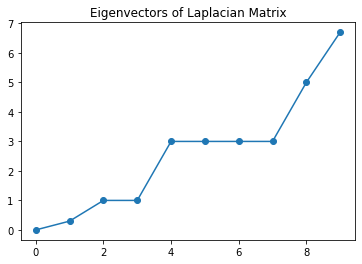

In [4]:
graph = np.array([
    [0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
])

eigvals, _ = get_laplacian_eigenvalues(graph)
plt.plot(eigvals, marker='o')
plt.title('Eigenvectors of Laplacian Matrix')
plt.show()

Raw graph cardinality: 7729
Filtered graph cardinality: 6113


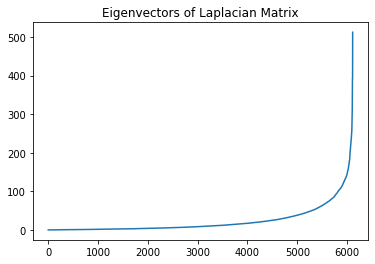

In [5]:
with open('graph.json', 'r') as f:
    raw_graph = json.load(f)
    print(f'Raw graph cardinality: {len(raw_graph.keys())}')
    graph = { k: v for k,v in raw_graph.items() if len(v['adj']) > 0 }
    print(f'Filtered graph cardinality: {len(graph.keys())}')
    adj_mat, author_ids = get_adjacency_matrix(graph)

eigvals, _ = get_laplacian_eigenvalues(adj_mat)
plt.plot(eigvals)
plt.title('Eigenvectors of Laplacian Matrix')
plt.show()

In [6]:
EPS = 1e-9
for treshold in [EPS, 0.25, 0.5, 1, 2, 4, 8]:
    lowest_idx = min([ i for i,v in enumerate(eigvals) if v > treshold ])
    print(f'Lowest i with eigenvectors < {treshold}: {lowest_idx} ({eigvals[lowest_idx]})')

Lowest i with eigenvectors < 1e-09: 156 (0.00019969654392412413)
Lowest i with eigenvectors < 0.25: 176 (0.25305464804474004)
Lowest i with eigenvectors < 0.5: 266 (0.5103073418294349)
Lowest i with eigenvectors < 1: 774 (1.0000000000000002)
Lowest i with eigenvectors < 2: 1273 (2.0000000000000004)
Lowest i with eigenvectors < 4: 2024 (4.000000000000001)
Lowest i with eigenvectors < 8: 2934 (8.000000000000004)


In [7]:
author_href = { v:k for k,v in author_ids.items() }
def get_adj(author_id):
    return [ author_ids[i['profile']['href']] for i in graph[author_href[author_id]]['adj'] ]

connected_graphs = []
visited = { node: False for node in author_ids.values() }
for node in author_ids.values():
    if visited[node]:
        continue
    tmp_graph = []
    stack = [node]
    while(len(stack) > 0):
        cur = stack[-1]
        stack.pop()
        if visited[cur]:
            continue
        visited[cur] = True
        tmp_graph.append(cur)
        for nxt in get_adj(cur):
            if adj_mat[node][nxt] > 0:
                stack.append(nxt)
    connected_graphs.append(tmp_graph)

connected_graphs.sort(key=lambda o : len(o), reverse=True)
print(f'Number of connected graphs: {len(connected_graphs)}')
for i in connected_graphs[:10]:
    print('-', len(i))

Number of connected graphs: 2435
- 44
- 42
- 39
- 34
- 31
- 28
- 28
- 27
- 26
- 26


In [8]:
def get_subgraph(node_list):
    sub_author_ids = { author: i for i,author in enumerate(node_list) }
    num_author = len(node_list)
    sub_adj_mat = np.zeros((num_author, num_author))
    for u in node_list:
        for v in node_list:
            sub_adj_mat[sub_author_ids[u]][sub_author_ids[v]] = adj_mat[u][v]
    return sub_adj_mat, sub_author_ids

In [9]:
def spectral_clustering(adj_mat):
    clustering = SpectralClustering(n_clusters=3, # Bikin yang lebih bagus
                                    affinity='precomputed',
                                    random_state=0).fit(adj_mat)
    return clustering.labels_

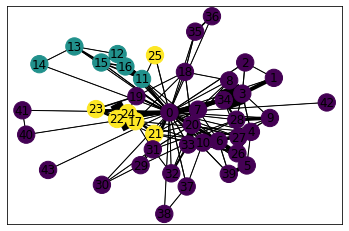

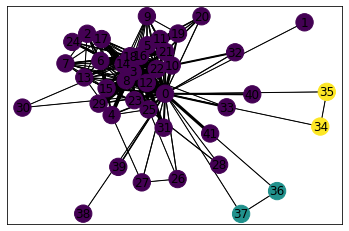

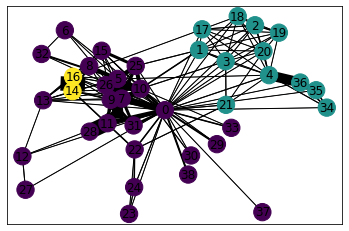

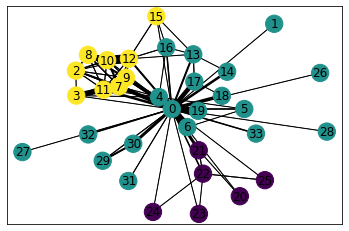

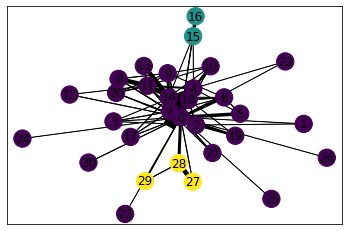

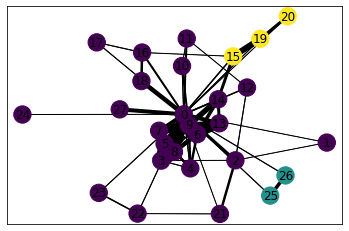

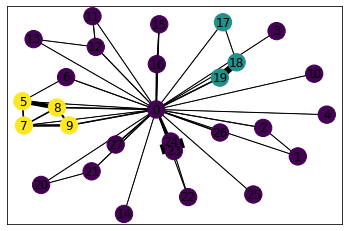

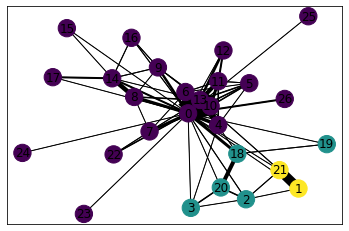

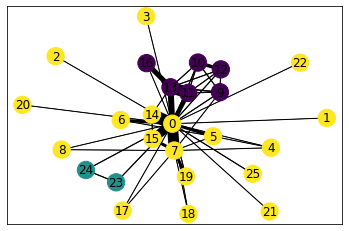

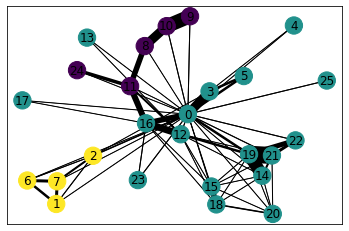

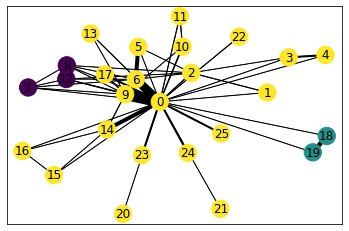

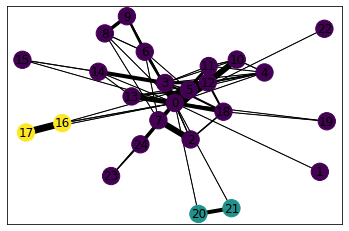

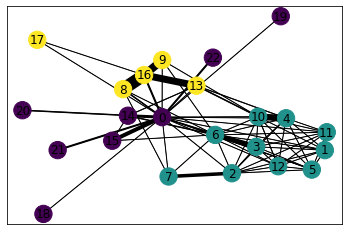

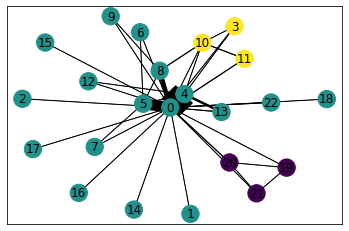

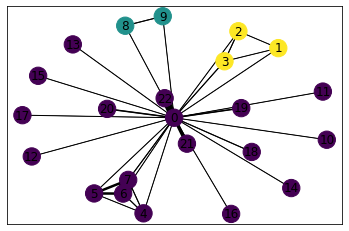

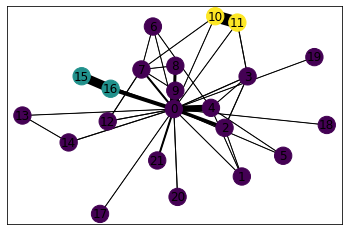

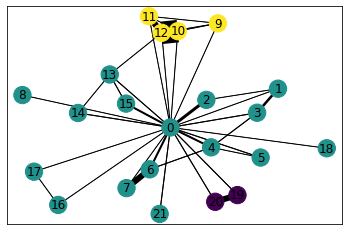

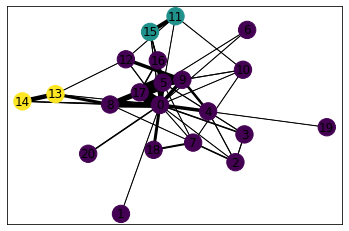

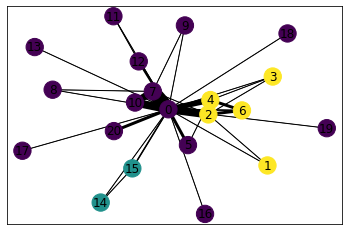

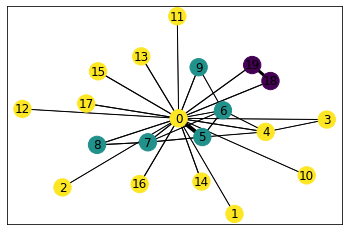

<Figure size 432x288 with 0 Axes>

In [16]:
def draw_graph(adj_mat, color_map, **kwargs):
    G = nx.Graph()
    n = len(color_map)
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(n):
            if adj_mat[i][j] > 0:
                G.add_edge(i,j,weight=adj_mat[i][j])

    pos = nx.spring_layout(G, seed=0)
    nx.draw_networkx(G, pos, node_color=color_map)
    for edge in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2]/2)
    plt.show()
    plt.clf()
    
for nodes in connected_graphs[:20]:
    sub_adj_mat, node_ids = get_subgraph(nodes)
    labels = spectral_clustering(sub_adj_mat)
    draw_graph(sub_adj_mat, labels)